In [16]:
import numpy                       
from matplotlib import pyplot                 
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

## Encoder toutes les valeurs en kilomètres et en heures.

In [17]:
def traffic(vmax,rhoinit,tmax):
    
    L = 11
    rhomax = 250
    nx = 51
    dx = L/(nx -1)
    dt = 0.001
    nt = int(tmax/dt)+1
    x = numpy.linspace(0,L,nx)
    rho0 = numpy.ones(nx)*rhoinit
    rho0[10:20] = 50
    rho=rho0.copy()
    
    for n in range(1, nt):  
        rhon = rho.copy()
        rho[1:] = rhon[1:]-vmax*(rhon[1:]*(1-rhon[1:]/rhomax)-rhon[0:-1]*\
                                 (1-rhon[0:-1]/rhomax))*dt/dx
        rho[0]=rhoinit
 
        if n==50:
            rho1=rho.copy() 
    
    r=numpy.empty_like([0,0,0],dtype=numpy.ndarray)
    r[0]=rho0
    r[1]=rho1
    r[2]=rho.copy()
    
    v=numpy.empty_like([0,0,0],dtype=numpy.ndarray)
    v=numpy.asarray([[vmax*(1-j/rhomax) for j in r[i]] for i in [0,1,2]])
    
    return r,v

In [18]:
def moyennetab(a):
    l=len(a)
    s=0
    for i in numpy.arange(0,l):
        s=s+a[i]
    m=s/l
    return m

Petite fonction permettant de calculer la moyenne arithmétique des données d'un tableau pris comme argument: la boucle _for_ somme toutes les données, puis on divise cette somme par le nombre d'éléments, c'est-à-dire la taille du tableau (_len(a)_).

Maintenant qu'on a toutes les fonctions nécessaires pour répondre aux questions, il suffit de les appeler pour les données de l'énoncé.

#### Exercice 1

In [47]:
[r,v]=traffic(80,10,0.1)

vmin=numpy.zeros(2)
vmin[0]=min(v[0])
vmin[1]=min(v[2])

for i,j in enumerate([0,6]):
    print("La vitesse minimum à t=", j ,"minutes est {:.2f} km/h".format(vmin[i]),\
          "c'est-à-dire, {:.2f} m/s".format(vmin[i]/3.6))


vmoy=moyennetab(v[1])
print("La vitesse moyenne à t= 3 minutes est {:.2f} km/h".format(vmoy),\
     "c'est-à-dire, {:.2f} m/s".format(vmoy/3.6))

La vitesse minimum à t= 0 minutes est 64.00 km/h c'est-à-dire, 17.78 m/s
La vitesse minimum à t= 6 minutes est 67.62 km/h c'est-à-dire, 18.78 m/s
La vitesse moyenne à t= 3 minutes est 74.29 km/h c'est-à-dire, 20.64 m/s


r et v reprennent les données calculées pour vmax=80 km/h, rhoinit=10 voitures/km, tmax=6 minutes. Ainsi, vmin[0] est le minimum du tableau de vitesse à t=0 et vmin[2] pour t=6 minutes. vmoy est la moyenne du tableau de vitesses à t=3 minutes.

#### Exercice 2

In [20]:
[r,v]=traffic(136,20,0.05)

vmin=numpy.zeros(2)
vmin[0]=min(v[0])
vmin[1]=min(v[2])

for i,j in enumerate([0,3]):
    print("La vitesse minimum à t=", j ,"minutes est {:.2f} km/h".format(vmin[i]),\
          "c'est-à-dire, {:.2f} m/s".format(vmin[i]/3.6))


vmoy=moyennetab(v[1])
print("La vitesse moyenne à t= 3 minutes est {:.2f} km/h".format(vmoy),\
     "c'est-à-dire, {:.2f} m/s".format(vmoy/3.6))

La vitesse minimum à t= 0 minutes est 108.80 km/h c'est-à-dire, 30.22 m/s
La vitesse minimum à t= 3 minutes est 111.55 km/h c'est-à-dire, 30.99 m/s
La vitesse moyenne à t= 3 minutes est 121.94 km/h c'est-à-dire, 33.87 m/s


r et v reprennent les données calculées pour vmax=136 km/h, rhoinit=20 voitures/km, tmax=3 minutes. Ainsi, vmin[0] est le minimum du tableau de vitesse à t=0 et vmin[2] pour t=3 minutes. vmoy est la moyenne du tableau de vitesses à t=3 minutes.

### Interprétation

Comme les paramètres n'ont pas encore été initiés en dehors de la fonction, il est nécessaire de le refaire maintenant pour les graphiques.

In [61]:
tmax=0.1
L = 11
rhomax = 250
nx = 51
dx = L/(nx -1)
dt = 0.001
nt = int(tmax/dt)+1
x = numpy.linspace(0,L,nx)
[r1,v1]=traffic(80,10,0.1)
[r2,v2]=traffic(136,20,0.05)

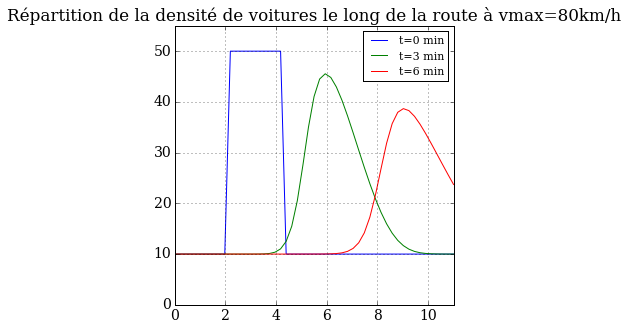

In [56]:
pyplot.figure(figsize=(5,5))
pyplot.xlim(0,11)
pyplot.ylim(0,55)
pyplot.plot(x,r1[0])
pyplot.plot(x,r1[1])
pyplot.plot(x,r1[2])
pyplot.grid(True)
pyplot.legend(["t=0 min","t=3 min","t=6 min"],fontsize=11,loc=1)
pyplot.title("Répartition de la densité de voitures le long de la route à vmax=80km/h")
pyplot.show()

On remarque d'abord que la situation initiale (bloc de voitures à vitesse constante) se déforme:

* Diminution de la densité maximale
* Evolution à vitesse presque constante du pic (vitesse de groupe)
* Apparition d'une asymétrie dans la répartition de densité autour du pic

En effet, l'équation décrivant l'évolution de la densité est une équation de diffusion: il y a donc un amortissement logique de "l'intensité de la densité". Mais de manière phénoménologique, ceci est encore plus compréhensible si on se rappelle que le nombre de voitures est constant sur la route.

Comme la vitesse initiale des voitures est de l'ordre de 70 km/h, et vu que la vitesse maximale autorisée est de 80 km/h, les premières voitures du bloc vont s'en échapper progressivement puisque la circulation est moins dense devant elle. Au fur et à mesure qu'elles avancent, elles vont libérer de la place, ce qui va favoriser le départ des voitures au rang suivant. Pendant ce temps, les voitures plus en arrière n'ont pas encore eu la possibilité d'avancer et évoluent donc toujours avec cette vitesse de départ moins grande.

Ceci provoque donc une dispersion de la concentration en voiture dans le bloc, ce qui est synonyme d'une diminution du pic de densité de voitures. De plus, cette dispersion est asymétrique puisque les voitures à l'avant vont plus vite.

Il peut sembler étrange que la vitesse du pic soit constante étant donné qu'on a la relation

##### insérer formule
et voyant que la densité du pic change.
En effet, ce n'est pas strictement le cas puisqu'on observe précisément que
##### valeur vitesse min des 3 courbes
Par conséquent, si la vitesse instantanée du pic à tendance à augmenter, il n'est pas possible que sa vitesse moyenne soit constante.

Cependant, la variation de vitesse entre t=0 et t=6 est de
##### 
ce qui est très faible. Théoriquement, si le pic avançait à v=
##### vmin t=0
, après 6 minutes il arriverait à la position x=
#####
On observe d'autre part que le pic de densité se trouve à la position x=
#####
La différence est tout à fait négligeable par rapport à la distance totale parcourue (de l'ordre du )
#####

\begin{equation}
\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x}=0
\end{equation}

\begin{equation}
\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial x}=0
\end{equation}

\begin{equation}
V=V_{max}(1-\frac{\rho}{\rho_{max}})
\end{equation}

\begin{equation}
F=V\rho
\end{equation}

\begin{equation}
F=F(\rho)=V(\rho)\rho=V_{max}\rho(1-\frac{\rho}{\rho_{max}})
\end{equation}

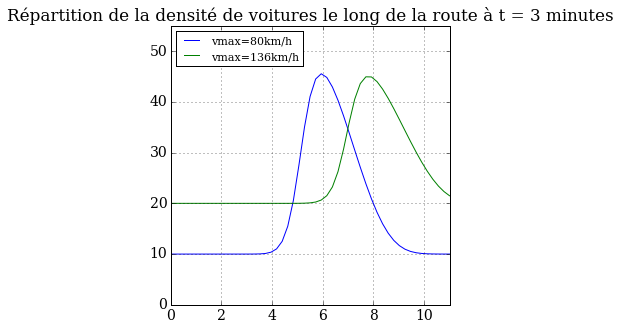

In [62]:
pyplot.figure(figsize=(5,5))
pyplot.xlim(0,11)
pyplot.ylim(0,55)
pyplot.grid(True)
pyplot.plot(x,r1[1])
pyplot.plot(x,r2[1])
pyplot.legend(["vmax=80km/h","vmax=136km/h"],fontsize=11,loc=2)
pyplot.title("Répartition de la densité de voitures le long de la route à t = 3 minutes")
pyplot.show()

Ici, nous avons changer de paramères simultanément : l'intensité initiale et la vitesse maximale pour les voitures. nous remarquons que la hauteur des pics est plus au moins la même. Cependant, le pic vert est plus en avant que le pic bleu puisque la vitesse de groupe du bleu est plus faible que celle du vert. De même le pic vert est plus étalé puisque le bloc de voitures de départ évoluait à une vitesse initiale plus élévée.

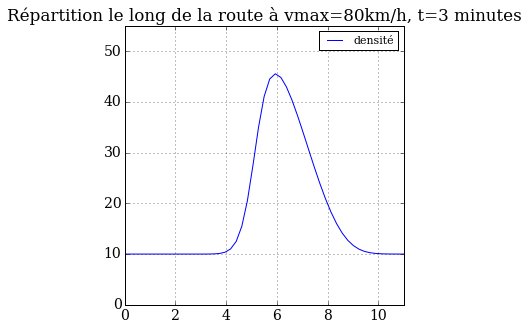

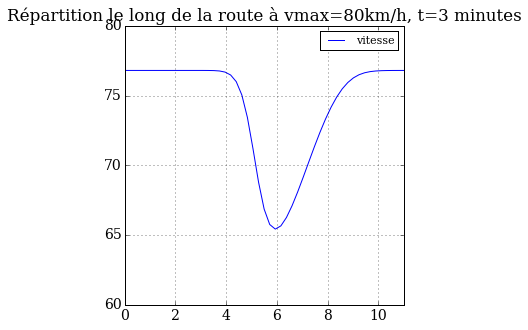

In [58]:
pyplot.figure(figsize=(5,5))
pyplot.grid(True)
pyplot.xlim(0,11)
pyplot.ylim(0,55)
pyplot.plot(x,r1[1])
pyplot.legend(["densité"],fontsize=11,loc=1)
pyplot.title("Répartition le long de la route à vmax=80km/h, t=3 minutes")
pyplot.show()
pyplot.figure(figsize=(5,5))
pyplot.grid(True)
pyplot.xlim(0,11)
pyplot.ylim(60,80)
pyplot.plot(x,v1[1])
pyplot.legend(["vitesse"],fontsize=11,loc=1)
pyplot.title("Répartition le long de la route à vmax=80km/h, t=3 minutes")
pyplot.show()

En regardant les graphiques pour la vitesse et la densité dans les mêmes conditions, on constate qu'ils sont tout à fait similaires. Ceci n'est pas étonnant puisqu'ils sont reliés par une relation linéaire, le graphique de la vitesse est simplement inversé et réduit.

La raison de ce creux a été expliquée en même temps que l'allure du pic de densité.

### Bonus : évolution

Si on se débarasse des contraintes de l'exercice, on peut modéliser l'évolution temporelle de la densité et de la vitesse le long de la route. Pour représenter ce graphique évolutif, nous avons simplement stocké tous les tableaux de données au fur et à mesure que la fonction _traffic_ les crée. Nous les avons ensuite appelés et fait défiler sous vos yeux ébahis. Nous ne pouvions pas utiliser cette méthode avant parce que cela aurait utiliser trop de mémoire inutilement.

### Conclusion

Nous avons utilisé ici un modèle très simplifier pour décrire l'évolution de la circulation sur une route au moins d'une équation de diffusion. Si on introduisait plus de précision dans le modèle, la résolution numérique de l'équation différentielle pourrait être une bonne approximation de différentes situations réelles.

Les seuls problèmes qui peuvent apparître sont liés à la quantité de données à emmagasiner, surtout si on veut augmenter la précision. Nous avons essayé d'optimiser les temps de calculs, mais nous ne pouvons pas nous passer des multiples tableaux. D'autres méthodes doivent être encore développées si c'est possible.